# Simulating a photon around a black hole
## 2D Case

This notebook relies on the equation:

$$\frac{d^2u}{d\phi^2} = \frac{3}{2} r_s u^2 - u$$

 Where $u = \frac{1}{r}$
 
 And $r_s$ is the Schwarzschild radius of the black hole: $r_s = \frac{2GM}{c^2}$
 
Let $v = \frac{du}{d\phi}$, then we can rewrite the equation as a system of first-order equations:

$$\frac{du}{d\phi} = v$$

$$\frac{dv}{d\phi} = \frac{3}{2} r_s u^2 - u$$

Let
$$x = \begin{bmatrix} u \\ v \end{bmatrix}$$

Then we can write the system as:
$$\frac{dx}{d\phi} = \begin{bmatrix} v \\ \frac{3}{2} r_s u^2 - u \end{bmatrix}$$

## Something more intuitive than $v$

By definition, $v = \frac{du}{d\phi}$. Therefore, if $v = 0$, the photon's initial velocity is tangential to the black hole. If $v = \infty$, the initial velocity points directly into the black hole.

I want to instead define the initial velocity with a 2D cartesian vector $\vec{d_0}$ at $\phi = 0$.

First, start with:

$$\frac{dr}{d\phi} = -\frac{1}{u^2} \frac{du}{d\phi} = -\frac{v}{u^2}$$

At $\phi = 0$, $x=r$ and $y=0$.

Therefore at $\phi = 0$,

$$\frac{dy}{dx} = \frac{d_{0y}}{d_{0x}}$$

Polar coordinates defines it as:

$$\frac{dy}{dx} = r \frac{d\phi}{dr}$$

Therefore, at $\phi = 0$,

$$\frac{d_{0y}}{d_{0x}} = \frac{r}{dr/d\phi}$$

Substitute $dr/d\phi = -v/u^2$ and $r=1/u$

$$\frac{d_{0y}}{d_{0x}} = \frac{1/u}{-v/u^2}$$

Simplifying,

$$\frac{d_{0y}}{d_{0x}} = -\frac{u}{v}$$

Solving for v,

$$v_0 = -u_0 \frac{d_{0x}}{d_{0y}}$$

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
# Since r_s is generally a really small number (under floating-point precision) we can set it to 1
R_S = 1


# Formatted for scipy's solve_ivp
def black_hole_ode(t, x):
    u, v = x
    du_dt = v
    dv_dt = (3/2) * R_S * u**2 - u
    return np.array([du_dt, dv_dt])

def escaped(t, x):
    u = x[0]
    r = 1 / u if u > 0 else np.inf
    return r - 50  # Stop when r > 50

escaped.terminal = True

# Event function: stop when photon falls into black hole (r < 1.5 * R_S)
def captured(t, x):
    u = x[0]
    r = 1 / u if u > 0 else np.inf
    return r - 1.5 * R_S  # Stop when r < 1.5 * R_S

captured.terminal = True
captured.direction = -1  # Only trigger when decreasing


In [3]:
# Initial conditions
u_0 = 1 / 10.0

# v_0 = 0, photon velocity is tangential to the black hole. v_0 = inf, photon velocity is radial to the black hole.
d_0 = np.array([-0.9, 0.3])
d_0 = d_0 / np.linalg.norm(d_0)

v_0 = -u_0 * d_0[0] / d_0[1]


def simulate_photon_trajectory(initial_u, initial_v):
    initial_conditions = [initial_u, initial_v]
    
    # Integration span
    phi_span = (0, 20 * np.pi)
    return solve_ivp(black_hole_ode, phi_span, initial_conditions,
                         t_eval=np.linspace(*phi_span, 1000),
                         events=[escaped, captured])


In [4]:
solution = simulate_photon_trajectory(u_0, v_0)

u_values = solution.y[0]
r_values = 1 / u_values
phi_values = solution.t

x_vals = r_values * np.cos(phi_values)
y_vals = r_values * np.sin(phi_values)

In [5]:
def plot_trajectory(trajectory_x, trajectory_y):
    plt.figure(figsize=(8, 8))
    plt.plot(trajectory_x, trajectory_y, 'b-', linewidth=1.5, label='Photon trajectory')
    
    # Mark start and end points
    plt.plot(trajectory_x[0], trajectory_y[0], 'go', markersize=10, label='Start')
    plt.plot(trajectory_x[-1], trajectory_y[-1], 'ro', markersize=10, label='End')
    
    # Draw the black hole event horizon
    circle = plt.Circle((0, 0), R_S, color='black', label='Event Horizon')
    plt.gca().add_patch(circle)
    
    # Draw the photon sphere (unstable circular orbit at r = 1.5 * R_S)
    photon_sphere = plt.Circle((0, 0), 1.5 * R_S, color='red', fill=False,
                               linestyle='--', linewidth=2, label='Photon Sphere')
    plt.gca().add_patch(photon_sphere)
    
    # Set equal aspect ratio and reasonable limits
    plt.axis('equal')
    # plt.xlim(-20, 20)
    # plt.ylim(-20, 20)
    plt.grid(True, alpha=0.3)
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.title('Photon Trajectory around a Black Hole', fontsize=14)
    plt.legend()

## Testing time requirement for rendering

Let's get a grasp on how long it takes per 1080*1920 integrations, which is required for rendering an image.

In [6]:
import timeit

t = timeit.timeit(
    lambda: simulate_photon_trajectory(u_0, v_0),
    number=100
)
print(f"{t / 100:.5f} seconds per integration")
print(f"{t / 100 * 1080 * 1920 / 60 / 60:.2f} hours per 1080*1920 integrations")

0.00053 seconds per integration
0.30 hours per 1080*1920 integrations


Yikes! One image will take at *least* 1.33 hours, but probably more after all the other computations I need to do. For a final renderer, this must be implemented on the GPU (or at least in C++). 

## 3D Initial Condition

One requirement for rendering this in 3D is taking the 3D initial condition (ray position, $\vec{r_0}$, and direction, $\hat{d_0}$) and converting it to the 2D polar coodinate system. This requires finding the plane where all the good stuff happens and projecting the 3D stuff onto that plane.

The normal of that plane is defined as:

$$\vec{N}=\vec{r_0} \times \hat{d_0}$$
$$\hat{N} = \frac{\vec{N}}{|N|}$$

Then we define two axes: radial ($e_r$) and tangential ($e_t$)

$$\vec{e_r} = \hat{r_0}$$
$$\vec{e_t} = \hat{N} \times e_r$$

Then, we will use:
$$u_0 = \frac{1}{|r_0|}$$
$$\phi_0 = 0$$
$$v_0 = -u_0\frac{d_r}{d_t} = -u_0\frac{\hat{d_0} \cdot \hat{e_r}}{\hat{d_0} \cdot \hat{e_t}}$$

The starting polar angle can be set to $\phi_0 = 0$ without loss of generality, since the oribital plane basis is constructed so the photon begins on the radial axis.

In [7]:
ray_origin = np.array([0, 0, 15])
ray_direction = np.array([0, 1, 0])
ray_direction = ray_direction / np.linalg.norm(ray_direction)

normal = np.cross(ray_origin, ray_direction)
normal = normal / np.linalg.norm(normal)

e_r = ray_origin / np.linalg.norm(ray_origin)
e_r = e_r / np.linalg.norm(e_r)

e_t = np.cross(normal, e_r)
e_t = e_t / np.linalg.norm(e_t)

u_0 = 1 / np.linalg.norm(ray_origin)
phi_0 = 0
v_0 = -np.dot(ray_direction, e_r) / (np.linalg.norm(ray_origin) * np.dot(ray_direction, e_t))

In [8]:
projected_3d = simulate_photon_trajectory(1 / np.linalg.norm(ray_origin), v_0)

In [9]:
projected_u_values = projected_3d.y[0]
projected_r_values = 1 / projected_u_values
projected_phi_values = projected_3d.t

projected_x_vals = projected_r_values * np.cos(projected_phi_values)
projected_y_vals = projected_r_values * np.sin(projected_phi_values)

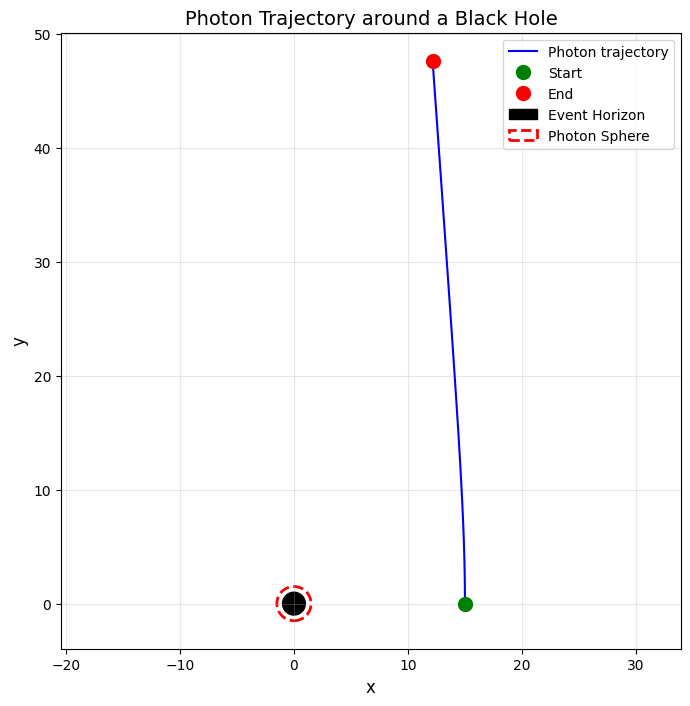

In [10]:
plot_trajectory(projected_x_vals, projected_y_vals)

## Converting back to 3D

Recall that,

$$u = \frac{1}{r} \Rightarrow r = \frac{1}{u}$$

At a general angle,

$$\hat{e_r}(\phi) = \hat{e_r} \cos(\phi) + \hat{e_t} \sin(\phi)$$
$$\hat{e_t}(\phi) = -\hat{e_r} \sin(\phi) + \hat{e_t} \cos(\phi)$$

Since the position is $r \hat{e_r}(\phi)$, we can write the 3D position as:
$$\vec{r}(\phi) = r \hat{e_r}(\phi) = \frac{1}{u} (\hat{e_r} \cos(\phi) + \hat{e_t} \sin(\phi))$$

The tangent to the trajectory is given by:
$$\frac{d\vec{r}}{d\phi} = \frac{dr}{d\phi} \hat{e_r}(\phi) + r \hat{e_t}(\phi)$$

Substituting $dr/d\phi = -v/u^2$ and $r=1/u$,
$$\vec{d} = -\frac{v}{u^2} (\hat{e_r} \cos(\phi) + \hat{e_t} \sin(\phi)) + \frac{1}{u} (-\hat{e_r} \sin(\phi) + \hat{e_t} \cos(\phi))$$

And finally:

$$\hat{d} = \frac{\vec{d}}{|\vec{d}|}$$

In [11]:
final_u = projected_u_values[-1]
final_phi = projected_phi_values[-1]
final_v = projected_3d.y[1][-1]  # Because x = [u, v]

final_pos_3d = (1 / final_u) * (e_r * np.cos(final_phi) + e_t * np.sin(final_phi))
final_dir_3d = (-final_v / final_u**2) * (e_r * np.cos(final_phi) + e_t * np.sin(final_phi)) + (1 / final_u) * (-e_r * np.sin(final_phi) + e_t * np.cos(final_phi))

In [12]:
print("Final 3D Position:", final_pos_3d)
print(f"Final 3D Direction (normalized): {final_dir_3d / np.linalg.norm(final_dir_3d)}")

Final 3D Position: [ 0.         47.62785493 12.16172397]
Final 3D Direction (normalized): [ 0.          0.99748986 -0.07080943]


In [14]:
print(final_u, final_v)

0.02034336387214421 -0.06120860528836673
